In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv


# Importing libraries

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [63]:
titanic_data = pd.read_csv("/kaggle/input/titanic/train.csv")

In [64]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Identifying patterns, outliers, and correlations.

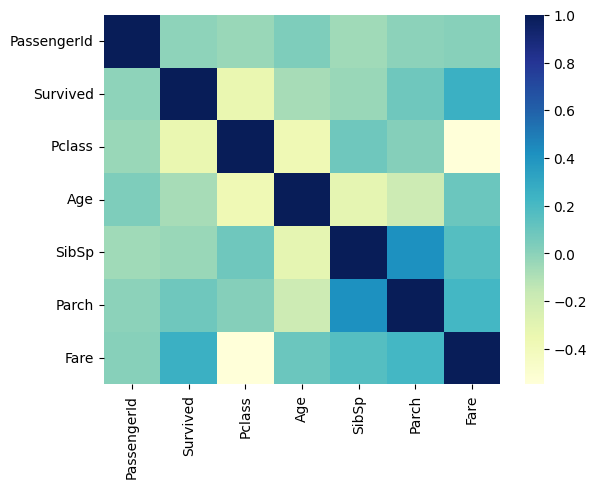

In [65]:
sns.heatmap(titanic_data.corr(numeric_only=True),cmap = 'YlGnBu')
plt.show()

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 342.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

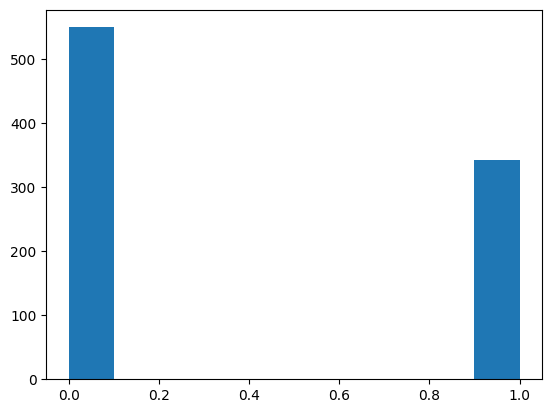

In [66]:
plt.hist(titanic_data["Survived"])

# Splitting the dataset using the stratified shuffle split

In [67]:
# from sklearn.model_selection import StratifiedShuffleSplit
# split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
# for train_indices,test_indices in split.split(titanic_data,titanic_data[["Survived","Pclass","Sex"]]):
#     strat_train_set = titanic_data.loc[train_indices]
#     strat_test_set = titanic_data.loc[test_indices]
from sklearn.model_selection import StratifiedShuffleSplit

def create_stratified_split(data, test_size, *stratify_cols):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_indices, test_indices in split.split(data, data[list(stratify_cols)]):
        train_set = data.loc[train_indices]
        test_set = data.loc[test_indices]
    return train_set, test_set

strat_train_set, strat_test_set = create_stratified_split(titanic_data, 0.2, "Survived", "Pclass", "Sex")

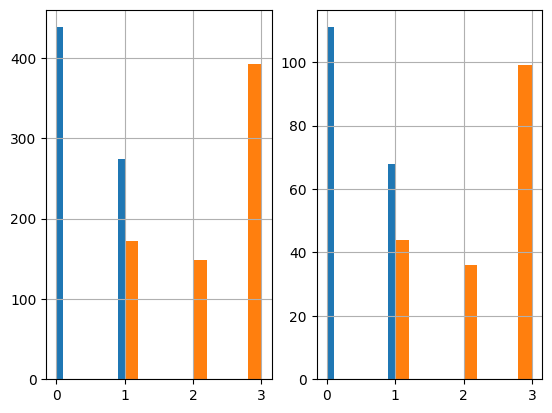

In [68]:
plt.subplot(1,2,1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(1,2,2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()
plt.show()

In [69]:
strat_train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
450,451,0,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,NaN,S
614,615,0,3,"Brocklebank, Mr. William Alfred",male,35.0,0,0,364512,8.0500,NaN,S
80,81,0,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.0000,NaN,S
601,602,0,3,"Slabenoff, Mr. Petco",male,NaN,0,0,349214,7.8958,NaN,S


In [70]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 450 to 220
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          575 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


# Defining classes to create pipeline to process data in a step-by-step manner.

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy="mean")
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Age'] = self.imputer.fit_transform(X[["Age"]])
        return X
    

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(sparse=False)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for feature, categories in [("Embarked", ["C","S","Q"]), ("Sex", ["Female","male"])]:
            matrix = self.encoder.fit_transform(X[[feature]])
            for i, category in enumerate(categories):
                X[category] = matrix[:, i]
        return X

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.columns_to_drop, axis=1, errors="ignore")

In [74]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer",AgeImputer()),("featureencoder",FeatureEncoder()),
                    ('feature_dropper', FeatureDropper(["Embarked","Name","Ticket","Cabin","Sex"]))])


In [ ]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [80]:
strat_train_set.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,male
450,451,0,2,36.000000,1,2,27.7500,0.0,0.0,1.0,0.0,1.0
253,254,0,3,30.000000,1,0,16.1000,0.0,0.0,1.0,0.0,1.0
614,615,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
80,81,0,3,22.000000,0,0,9.0000,0.0,0.0,1.0,0.0,1.0
601,602,0,3,29.847252,0,0,7.8958,0.0,0.0,1.0,0.0,1.0


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [82]:
X = strat_train_set.drop("Survived",axis=1)
y = strat_train_set["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a logistic regression model using liblinear as solver as it is better for smaller datasets
model = LogisticRegression(solver='liblinear')  

# Training the model on the training data
model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7762237762237763


In [83]:
testing_set = pd.read_csv("/kaggle/input/titanic/test.csv")

In [84]:
testing_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
testing_set = pipeline.fit_transform(testing_set)

In [86]:
testing_set.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,male
0,892,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0


In [87]:
testing_set = testing_set.ffill()

In [88]:
testing_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [89]:
final_preds = model.predict(testing_set)
final_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [51]:
final_df = pd.DataFrame(testing_set['PassengerId'])
final_df['Survived'] = final_preds
final_df.to_csv("predictions.csv",index=False)

In [53]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
